## Imports and functions

In [1]:
import xarray as xr
import dask.array
import matplotlib.pyplot as plt
import math
import numpy as np
from numpy import f2py
import pandas as pd

In [2]:
# Fortran codes imports

import ddensity
import snowtemp

In [3]:
def median_spacetime_filtering(ds, min_periods_val, time_window=11, x_span=11, y_span=11):
    '''
    Function to apply median filtering in time and space
    Args:
        ds: clean data dataset
        time_window: time windo on which to apply median filter [index]
        x_span: x-span on which to apply filtering, unit [index]
        y_span: y-span on which to apply filtering, unit [index]
    Returns:
    '''
    # TODO take out time median
    # ds['snow_surface'] = ds['mean'].rolling(time=time_window, min_periods=min_periods_val, center=True).median()
    # print(f'---> Median filtering in time with a window of {time_window}')
    ds['snow_surface'] = ds['mean'].rolling({'x': x_span, 'y': y_span}, min_periods=min_periods_val, center=True).median()
    print(f'---> Median filtering in space with a window [{x_span}, {y_span}]')
    
    # note that a skipna argument is available (useful?) in xarray.DataArray.median()


In [4]:
def get_snow_events_deprecated(ds, x_sel, y_sel, time_window_std, time_window_mean, time_window_mean_diff, mean_diff_offset):
    '''
    Function that computes the dates of start and end times of snow events (snow accumulation and erosion)
    The events are defined as periods during which the snow-depth rolling standard deviation is higher than 
    a given threshold (set to 0.02 here)
    We distinguish between accumulation and erosion of snow by looking at the sign of the difference between
    a rolling mean centerd left and a rolling mean centered right
    Args:
        ds: clean dataset with 'snow_surface' variable
        x_sel: x coordinate of the point of interest (index)
        y_sel: y coordinate of the point of interest (index)
        time_window_std: size of the rolling window to compute standard deviation
        time_window_mean: size of the rolling window to compute each mean (left and right)
        time_window_mean_diff: size of the rolling window to compute the difference between the two rolling means
        mean_diff_offset: index offset to take into account the lag due to rolling window size
    Returns:
        start_accumulation_indices: list of time indices corresponding to the start of an accumulation event
        start_erosion_indices: list of time indices corresponding to the end of an accumulation event
        end_accumulation_indices: list of time indices corresponding to the start of an erosion event
        end_erosion_indices: list of time indices corresponding to the end of an erosion event
    '''
    
    stdev = ds.isel(x=x_sel, y=y_sel).snow_surface.rolling(time=time_window_std, center=True).std(dim='time').values
    
    mean_right_minus_mean_left = ds.isel(x=x_sel, y=y_sel).snow_surface.rolling(time=time_window_mean, center=True).mean(dim='time') - ds.isel(x=x_sel, y=y_sel).snow_surface.rolling(time=time_window_mean, center=False).mean(dim='time')
    mean_right_minus_mean_left = mean_right_minus_mean_left.rolling(time=time_window_mean_diff, center=True).mean(dim='time').values

    snow_events_occurrences = stdev > 0.015   # booleans           # TODO make this modular
    snow_events_occurrences = np.diff(snow_events_occurrences.astype(int))   # 1 or 0
    start_time_indices = np.where(snow_events_occurrences==1)[0]
    end_time_indices = np.where(snow_events_occurrences==-1)[0]
    
    start_accumulation_indices = []
    start_erosion_indices = []
    end_accumulation_indices = []
    end_erosion_indices = []
    
    for index in range(len(start_time_indices)):
        if mean_right_minus_mean_left[start_time_indices[index] + mean_diff_offset] >= 0:
            start_accumulation_indices.append(start_time_indices[index])
            end_accumulation_indices.append(end_time_indices[index])
        else:
            start_erosion_indices.append(start_time_indices[index])
            end_erosion_indices.append(end_time_indices[index])
        
    return(start_accumulation_indices, start_erosion_indices, end_accumulation_indices, end_erosion_indices)


In [5]:
def get_snow_events_bis(ds, x_sel, y_sel, time_window_std):
    '''
    Function that computes the dates of start and end times of snow events (snow accumulation and erosion)
    The events are defined as periods during which the snow-depth rolling standard deviation is higher than 
    a given threshold (set to 0.02 here)
    We distinguish between accumulation and erosion of snow by looking at the snow depth before and after the event
    Args:
        ds: clean dataset with 'snow_surface' variable
        x_sel: x coordinate of the point of interest (index)
        y_sel: y coordinate of the point of interest (index)
        time_window_std: size of the rolling window to compute standard deviation
    Returns:
        start_accumulation_indices: list of time indices corresponding to the start of an accumulation event
        start_erosion_indices: list of time indices corresponding to the end of an accumulation event
        end_accumulation_indices: list of time indices corresponding to the start of an erosion event
        end_erosion_indices: list of time indices corresponding to the end of an erosion event
    '''
    
    stdev = ds.isel(x=x_sel, y=y_sel).snow_surface.rolling(time=time_window_std, center=True).std(dim='time').values
    
    snow_events_occurrences = stdev > 0.015   # booleans           # TODO make this modular
    snow_events_occurrences = np.diff(snow_events_occurrences.astype(int))   # 1 or 0
    start_time_indices = np.where(snow_events_occurrences==1)[0]
    end_time_indices = np.where(snow_events_occurrences==-1)[0]
    
    start_accumulation_indices = []
    start_erosion_indices = []
    end_accumulation_indices = []
    end_erosion_indices = []
    
    for index in range(len(start_time_indices)):
        
        start_date = start_time_indices[index]
        end_date = end_time_indices[index]
    
        start_snow_height = float(ds.snow_surface.isel(x=x_sel, y=y_sel, time=start_date))
        end_snow_height = float(ds.snow_surface.isel(x=x_sel, y=y_sel, time=end_date))
    
        if start_snow_height < end_snow_height:
            start_accumulation_indices.append(start_time_indices[index])
            end_accumulation_indices.append(end_time_indices[index])
        else:
            start_erosion_indices.append(start_time_indices[index])
            end_erosion_indices.append(end_time_indices[index])
        
    return(start_accumulation_indices, start_erosion_indices, end_accumulation_indices, end_erosion_indices)


In [6]:
def get_change_in_snow_depth(ds, start_events, end_events, index_of_event, x_sel, y_sel):
    '''
    Function to get snow height difference (absolute value) before and after an event
    Args:
        ds: dataset containing the snow-depth data ('snow_surface' variable)
        start_events: list of time indices at which the events of interest (accumulation or erosion) started
        end_events: list of time indices at which the events of interest (accumulation or erosion) ended
        index_of_event: index of event of interest in the lists of time indices
        x_sel: index of the x-coordinate of the point of interest
        y_sel: index of the y-coordinate of the point of interest
    Returns:
        difference in snow-depth between the start and end of the event
    '''
    
    start_date = start_events[index_of_event]
    end_date = end_events[index_of_event]
    
    start_snow_height = float(ds.snow_surface.isel(x=x_sel, y=y_sel, time=start_date))
    end_snow_height = float(ds.snow_surface.isel(x=x_sel, y=y_sel, time=end_date))
    difference = abs(end_snow_height - start_snow_height)
    
    return(difference)

## Data and params

In [7]:
# data_dec_jan_fev = xr.open_mfdataset('/home/mabonnet/Desktop/data/Data_netcdf/*/202*.nc', chunks={'x': 20,'y': 20, 'time': 10})
# data_dec_jan_fev

In [8]:
# Get data from files

# data_dec_jan_fev = xr.open_mfdataset('/home/mabonnet/Desktop/data/Data_netcdf/*/202*.nc', chunks={'x': 20,'y': 20, 'time': 10})
# data_dec_jan_fev.isel(x=slice(100,122), y=slice(45,67)).to_netcdf('data_dec_jan_feb_pit.nc')
data_dec_jan_feb = xr.open_dataset('data_dec_jan_feb_pit.nc')

data_set_used = data_dec_jan_feb

# Pre-processing to get clean data

data_set_used = data_set_used.ffill(dim='time')
median_spacetime_filtering(data_set_used, 11)
# new_median_spacetime_filtering(data_set_used, 11, y_span=15)
data_set_used['snow_surface'] = data_set_used['snow_surface'] - data_set_used['snow_surface'].min() 


---> Median filtering in space with a window [11, 11]


In [25]:
# Defining parameters for snow events detection

x_sel = 20
y_sel = 20
time_window_std = 17
time_window_mean = 11
time_window_mean_diff = 11
mean_diff_offset = 2

# Initial state for compaction/temperature model, with 1 layers

max_nb_of_layers = 25
nb_iterations = 70000

ro_layer = np.zeros((max_nb_of_layers, 1))
ro_layer[0] = 150
tf = 0
dt = 100
ro_water = 1000
ro_ice = 910
t_old = np.zeros((max_nb_of_layers, 1))
t_old[0] = -5
jj = 1
dy_snow = np.zeros((max_nb_of_layers, 1))
dy_snow[0] = 0.2
a1 = 0.0013
a2 = 0.021
gamma = np.zeros((max_nb_of_layers, 1))
gamma[0] = 0
tsfc = -15
cp_snow = 2.1
melt_flag = np.zeros((max_nb_of_layers, 1))
melt_flag[0] = 0

# Initialize arrays to keep track of variables in time

ro_layer_evolution = [ro_layer]
depth_evolution = [dy_snow]
temperature_evolution = [t_old]


## Snow events timing

In [21]:

# results = get_snow_events(data_set_used, x_sel, y_sel, time_window_std, time_window_mean, time_window_mean_diff, mean_diff_offset)
results = get_snow_events_bis(data_set_used, x_sel, y_sel, time_window_std)
start_accumulation = results[0]
start_erosion = results[1]
end_accumulation = results[2]
end_erosion = results[3]

# Convert end times into more manageable orders of magnitude

end_accumulation_times = data_set_used.snow_surface.isel(x=x_sel, y=y_sel, time=end_accumulation)
end_accumulation_times = (pd.to_datetime(end_accumulation_times.time).astype(int) - 1638796500000000000)/1000000000
# 1638796500000000000 is the first time point in data_dec_jan_feb > TODO make modular
# TODO units ???

end_erosion_times = data_set_used.snow_surface.isel(x=x_sel, y=y_sel, time=end_erosion)
end_erosion_times = (pd.to_datetime(end_erosion_times.time).astype(int) - 1638796500000000000)/1000000000

# print(end_accumulation_times, end_erosion_times)

/tmp/ipykernel_22938/329830003.py:19: DeprecationWarning: Reductions are applied along the rolling dimension(s) '['time']'. Passing the 'dim' kwarg to reduction operations has no effect.
  stdev = ds.isel(x=x_sel, y=y_sel).snow_surface.rolling(time=time_window_std, center=True).std(dim='time').values


In [22]:
# Update variables at each timepoint

# Define indices of first accumulation/erosion events coming up (updated when their time is past)
accumulation_index = 0
erosion_index = 0

for i in range(nb_iterations):
    if accumulation_index<len(end_accumulation_times) and i*dt>=end_accumulation_times[accumulation_index]:
        # TODO put all this in a function
        ddepth = get_change_in_snow_depth(data_set_used, start_accumulation, end_accumulation, accumulation_index, x_sel, y_sel)
        ro_layer[jj] = 150
        t_old[jj] = -5
        dy_snow[jj] = ddepth  # ??? TODO
        gamma[jj] = 0
        melt_flag[jj] = 0
        jj += 1
        accumulation_index += 1
    
    if erosion_index<len(end_erosion_times) and i*dt>=end_erosion_times[erosion_index]:
        # TODO put all this in a function
        ddepth = get_change_in_snow_depth(data_set_used, start_erosion, end_erosion, erosion_index, x_sel, y_sel)
        if dy_snow[jj-1] > ddepth:
            dy_snow[jj-1] = dy_snow[jj-1] - ddepth
        else:
            jj -= 1
            dy_snow[jj] = 0  # ??? TODO
            ro_layer[jj] = 0  # ??? TODO
            t_old[jj] = 0
            gamma[jj] = 0
            melt_flag[jj] = 0
        erosion_index += 1
    
    # Update layers' parameters
    ro_layer, dy_snow = ddensity.ddensity_ml(ro_layer, tf, dt, ro_water, 
                                         ro_ice, t_old, jj, dy_snow, a1, a2)
    t_old = snowtemp.snowtemp_ml(gamma, t_old, tsfc, jj, dt, ro_layer, cp_snow, 
                                 tf, dy_snow, melt_flag)
    
    # Keep track of events
    ro_layer_evolution.append(ro_layer)
    depth_evolution.append(dy_snow)
    temperature_evolution.append(t_old)

## Plot evolution of snowpack

In [23]:
layer1 = [depth_evolution[i][0] for i in range(len(depth_evolution))]
layer2 = [layer1[i] + depth_evolution[i][1] for i in range(len(depth_evolution))]
layer3 = [layer2[i] + depth_evolution[i][2] for i in range(len(depth_evolution))]
layer4 = [layer3[i] + depth_evolution[i][3] for i in range(len(depth_evolution))]
layer5 = [layer4[i] + depth_evolution[i][4] for i in range(len(depth_evolution))]
layer6 = [layer5[i] + depth_evolution[i][5] for i in range(len(depth_evolution))]
layer7 = [layer6[i] + depth_evolution[i][6] for i in range(len(depth_evolution))]
layer8 = [layer7[i] + depth_evolution[i][7] for i in range(len(depth_evolution))]
layer9 = [layer8[i] + depth_evolution[i][8] for i in range(len(depth_evolution))]
layer10 = [layer9[i] + depth_evolution[i][9] for i in range(len(depth_evolution))]
layer11 = [layer10[i] + depth_evolution[i][10] for i in range(len(depth_evolution))]
layer12 = [layer11[i] + depth_evolution[i][11] for i in range(len(depth_evolution))]

/home/mabonnet/miniconda3/envs/awk/lib/python3.10/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Text(0.5, 1.0, 'Comparison between lidar-measured and simulated snow depth')

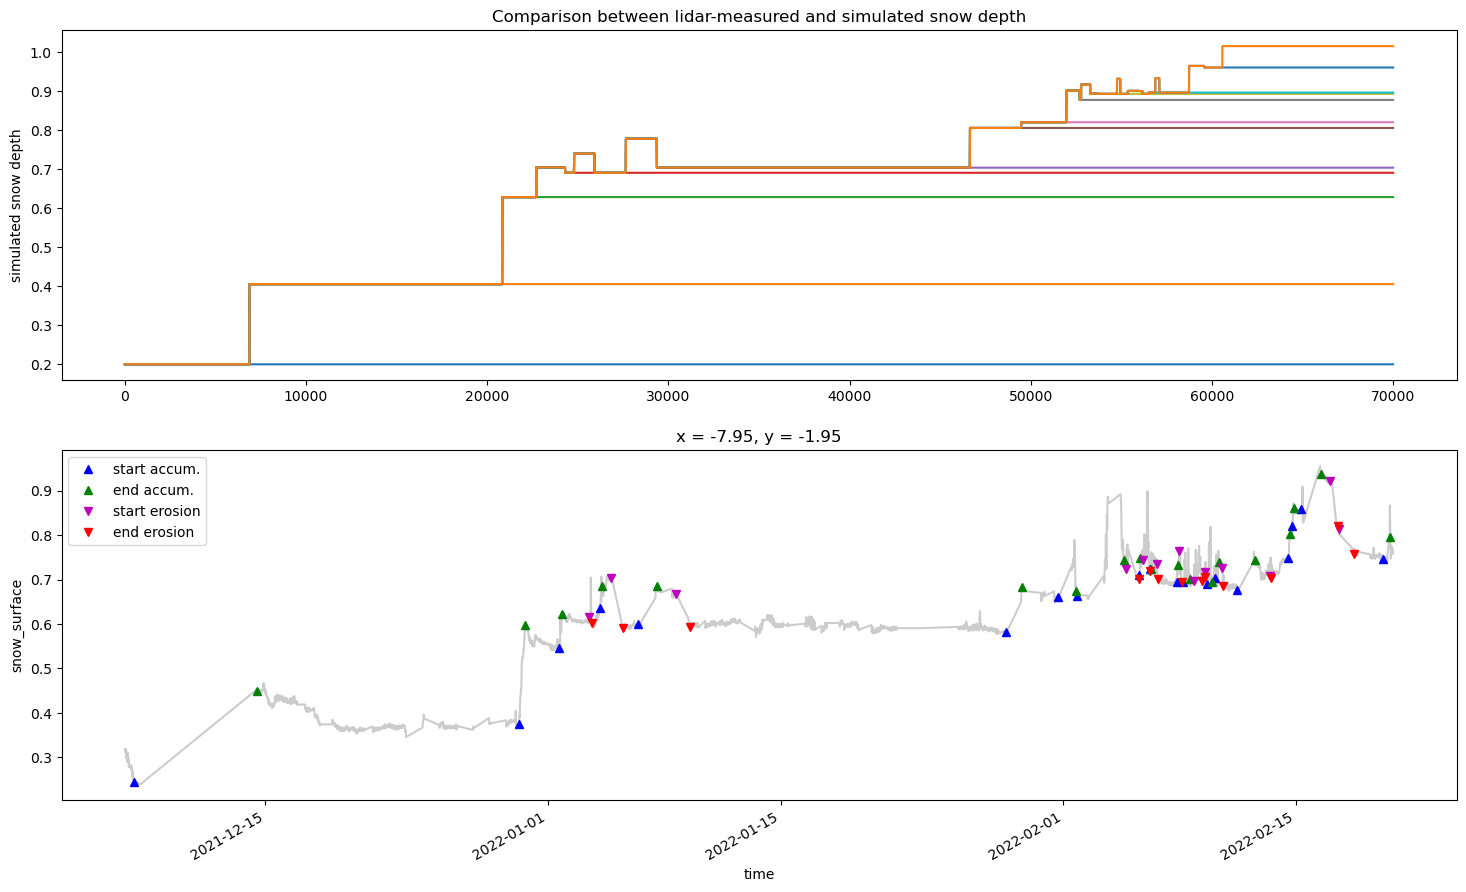

In [24]:
fig, ax = plt.subplots(2, 1, sharex=False, figsize=(18, 10))

ax[0].plot(layer1, label='layer 1')
ax[0].plot(layer2, label='layer 2')
ax[0].plot(layer3, label='layer 3')
ax[0].plot(layer4, label='layer 4')
ax[0].plot(layer5, label='layer 5')
ax[0].plot(layer6, label='layer 6')
ax[0].plot(layer7, label='layer 7')
ax[0].plot(layer8, label='layer 8')
ax[0].plot(layer9, label='layer 9')
ax[0].plot(layer10, label='layer 10')
ax[0].plot(layer11, label='layer 11')
ax[0].plot(layer12, label='layer 12')

ax[0].set_ylabel('simulated snow depth')

data_set_used.isel(x=x_sel, y=y_sel).snow_surface.plot(c='k', alpha=0.2, ax=ax[1])

data_set_used.isel(x=x_sel, y=y_sel, time=start_accumulation).snow_surface.plot(c='b', marker='^', markersize=6, linestyle='None', label='start accum.', ax=ax[1])
data_set_used.isel(x=x_sel, y=y_sel, time=end_accumulation).snow_surface.plot(c='g', marker='^', markersize=6, linestyle='None', label='end accum.', ax=ax[1])
data_set_used.isel(x=x_sel, y=y_sel, time=start_erosion).snow_surface.plot(c='m', marker='v', markersize=6, linestyle='None', label='start erosion', ax=ax[1])
data_set_used.isel(x=x_sel, y=y_sel, time=end_erosion).snow_surface.plot(c='r', marker='v', markersize=6, linestyle='None', label='end erosion', ax=ax[1])
ax[1].legend()

ax[0].set_title('Comparison between lidar-measured and simulated snow depth')

# fig.savefig('measured_vs_simul_snow_depth_2.png')

DatetimeIndex(['2021-12-06 00:00:00', '2021-12-06 00:01:40',
               '2021-12-06 00:03:20', '2021-12-06 00:05:00',
               '2021-12-06 00:06:40', '2021-12-06 00:08:20',
               '2021-12-06 00:10:00', '2021-12-06 00:11:40',
               '2021-12-06 00:13:20', '2021-12-06 00:15:00',
               ...
               '2022-02-25 00:11:40', '2022-02-25 00:13:20',
               '2022-02-25 00:15:00', '2022-02-25 00:16:40',
               '2022-02-25 00:18:20', '2022-02-25 00:20:00',
               '2022-02-25 00:21:40', '2022-02-25 00:23:20',
               '2022-02-25 00:25:00', '2022-02-25 00:26:40'],
              dtype='datetime64[ns]', length=70001, freq='100S')


/home/mabonnet/miniconda3/envs/awk/lib/python3.10/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/home/mabonnet/miniconda3/envs/awk/lib/python3.10/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/home/mabonnet/miniconda3/envs/awk/lib/python3.10/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with dif

AttributeError: 'Rectangle' object has no property 'c'

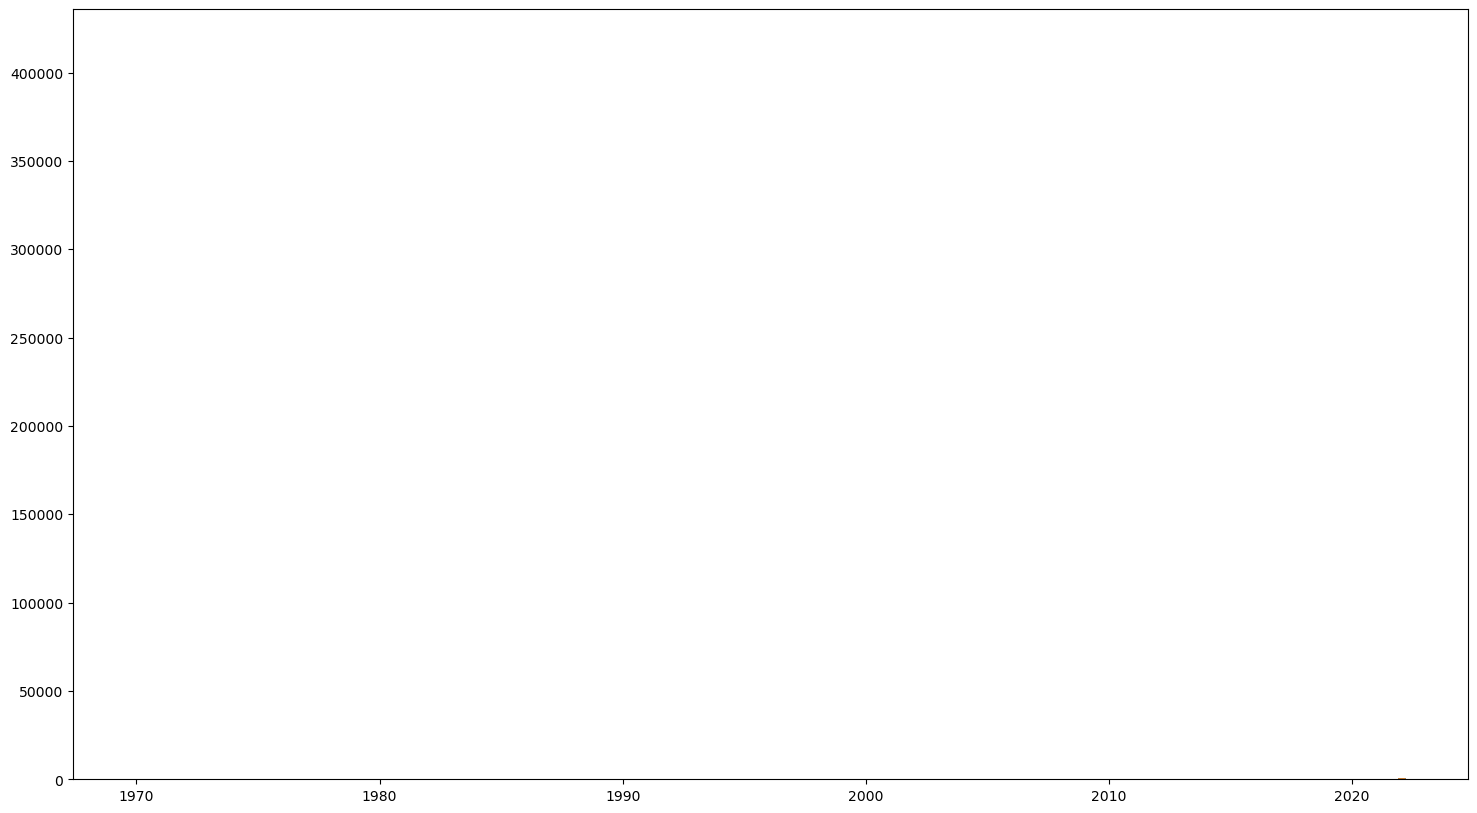

In [14]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(18, 10))

data_start_date = pd.to_datetime('2021-12-06T00:00')
times = pd.date_range(start=data_start_date,freq=str(dt)+'S',periods=nb_iterations+1)
print(times)

plt.plot(times, layer1, label='layer 1')
plt.plot(times, layer2, label='layer 2')
plt.plot(times, layer3, label='layer 3')
plt.plot(times, layer4, label='layer 4')
plt.plot(times, layer5, label='layer 5')
plt.plot(times, layer6, label='layer 6')
plt.plot(times, layer7, label='layer 7')
plt.plot(times, layer8, label='layer 8')
plt.plot(times, layer9, label='layer 9')
plt.plot(times, layer10, label='layer 10')
plt.plot(times, layer11, label='layer 11')
plt.plot(times, layer12, label='layer 12')

# ax[0].set_ylabel('simulated snow depth')

data_set_used.snow_surface.plot(c='k', alpha=0.2)#, ax=ax[0])

data_set_used.isel(time=start_accumulation).snow_surface.plot(c='b', marker='^', markersize=6, linestyle='None', label='start accum.')#, ax=ax[0])
data_set_used.isel(time=end_accumulation).snow_surface.plot(c='g', marker='^', markersize=6, linestyle='None', label='end accum.')#, ax=ax[0])
data_set_used.isel(time=start_erosion).snow_surface.plot(c='m', marker='v', markersize=6, linestyle='None', label='start erosion')#, ax=ax[0])
data_set_used.isel(time=end_erosion).snow_surface.plot(c='r', marker='v', markersize=6, linestyle='None', label='end erosion')#, ax=ax[0])
plt.legend()

plt.title('Comparison between lidar-measured and simulated snow depth')

# fig.savefig('measured_vs_simul_snow_depth_2.png')